# Notebook-3: Conference Experiments (Ablations + Threshold Tuning + Robustness)

This notebook runs publishable experiments on LGG MRI segmentation:
- Ablation A: Self-attention ON vs OFF (same backbone)
- Ablation B: Transfer learning strategy (encoder frozen vs full fine-tune)
- Threshold sweep: best threshold for Dice/IoU on validation
- Patient-level metrics + bootstrap 95% CI
- Paper-ready plots + LaTeX tables exported to `/kaggle/working/paper_outputs/`

Prerequisites:
- Dataset attached (kaggle_3m).
- This notebook is self-contained (rebuilds df + splits).


In [1]:
import os, re, glob, random, math, time
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms.functional as TF


In [2]:
# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,

    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "axes.linewidth": 1.2,

    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------------
# Reproducibility
# -------------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True


In [3]:
CFG = {
    "img_size": 256,
    "batch_size": 16,
    "num_workers": 2,
    "epochs": 8,                 # keep smaller for ablation sweep
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "threshold_default": 0.5,

    # speed knobs
    "fast_dev_run": False,       # True = tiny subset quick check
    "fast_train_slices": 400,
    "fast_val_slices": 200,
}

OUT_DIR = Path("/kaggle/working/paper_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CFG


{'img_size': 256,
 'batch_size': 16,
 'num_workers': 2,
 'epochs': 8,
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'device': 'cuda',
 'threshold_default': 0.5,
 'fast_dev_run': False,
 'fast_train_slices': 400,
 'fast_val_slices': 200}

## Data loading (slice-level), patient-safe split

We rebuild the slice dataframe from `kaggle_3m` and create a patient-level split
(train/val/test). This matches the anti-leakage protocol.


In [4]:
KAGGLE_INPUT = Path("/kaggle/input")
candidates = list(KAGGLE_INPUT.glob("**/kaggle_3m"))
print("Found candidates:", [str(p) for p in candidates[:10]])

if len(candidates) == 0:
    raise FileNotFoundError("Could not find 'kaggle_3m' under /kaggle/input. Attach the dataset.")
DATA_ROOT = candidates[0]
DATA_ROOT


Found candidates: ['/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m', '/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m']


PosixPath('/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m')

In [5]:
def to_key(path):
    base = Path(path).name
    if base.endswith("_mask.tif"):
        base = base.replace("_mask.tif", "")
    else:
        base = base.replace(".tif", "")
    return base

def patient_id_from_path(path):
    return Path(path).parent.name

def slice_index_from_key(k):
    m = re.search(r"_(\d+)$", k)
    return int(m.group(1)) if m else np.nan

all_tifs = sorted(glob.glob(str(DATA_ROOT / "*" / "*.tif")))
mask_tifs = sorted([p for p in all_tifs if p.endswith("_mask.tif")])
img_tifs  = sorted([p for p in all_tifs if not p.endswith("_mask.tif")])

img_map = {to_key(p): p for p in img_tifs}
msk_map = {to_key(p): p for p in mask_tifs}
keys = sorted(set(img_map.keys()) & set(msk_map.keys()))

df = pd.DataFrame({
    "key": keys,
    "image_path": [img_map[k] for k in keys],
    "mask_path":  [msk_map[k] for k in keys],
})
df["patient_id"] = df["image_path"].apply(patient_id_from_path)
df["slice_idx"] = df["key"].apply(slice_index_from_key)
df = df.sort_values(["patient_id", "slice_idx", "key"]).reset_index(drop=True)

print("Slices:", len(df), "| Patients:", df["patient_id"].nunique())
df.head()


Slices: 3929 | Patients: 110


,key,image_path,mask_path,patient_id,slice_idx
0,TCGA_CS_4941_19960909_1,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,1
1,TCGA_CS_4941_19960909_2,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,2
2,TCGA_CS_4941_19960909_3,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,3
3,TCGA_CS_4941_19960909_4,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,4
4,TCGA_CS_4941_19960909_5,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,5


In [6]:
patients = df["patient_id"].drop_duplicates().tolist()
rng = np.random.default_rng(SEED)
rng.shuffle(patients)

n = len(patients)
train_pat = set(patients[: int(0.8*n)])
val_pat   = set(patients[int(0.8*n): int(0.9*n)])
test_pat  = set(patients[int(0.9*n):])

def assign_split(pid):
    if pid in train_pat: return "train"
    if pid in val_pat: return "val"
    return "test"

df["split"] = df["patient_id"].apply(assign_split)

print(df["split"].value_counts())
print(df.groupby("split")["patient_id"].nunique())


split
train    3068
test      435
val       426
Name: count, dtype: int64
split
test     11
train    88
val      11
Name: patient_id, dtype: int64


## Torchvision augmentation (no cv2)

We keep a lightweight augmentation pipeline that is stable under NumPy 2.x.


In [7]:
class TorchvisionAugment:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img, msk):
        # img: numpy HWC uint8, msk: numpy HW uint8 {0,1}
        img_t = TF.to_tensor(img)                      # (3,H,W) float32 [0,1]
        msk_t = torch.from_numpy(msk).unsqueeze(0).float()

        if self.train:
            if torch.rand(1).item() < 0.5:
                img_t = TF.hflip(img_t); msk_t = TF.hflip(msk_t)
            if torch.rand(1).item() < 0.2:
                img_t = TF.vflip(img_t); msk_t = TF.vflip(msk_t)

            angle = float((torch.rand(1).item() - 0.5) * 24.0)  # [-12, 12]
            img_t = TF.rotate(img_t, angle, interpolation=TF.InterpolationMode.BILINEAR)
            msk_t = TF.rotate(msk_t, angle, interpolation=TF.InterpolationMode.NEAREST)

            if torch.rand(1).item() < 0.25:
                b = 0.9 + 0.2 * torch.rand(1).item()
                c = 0.9 + 0.2 * torch.rand(1).item()
                img_t = TF.adjust_brightness(img_t, b)
                img_t = TF.adjust_contrast(img_t, c)

            if torch.rand(1).item() < 0.15:
                try:
                    img_t = TF.gaussian_blur(img_t, kernel_size=[3, 3], sigma=[0.1, 1.2])
                except Exception:
                    pass

        return img_t, msk_t

train_tfms = TorchvisionAugment(train=True)
val_tfms   = TorchvisionAugment(train=False)


In [8]:
def load_tif(path):
    return np.array(Image.open(path))

def to_mask01(msk):
    if msk.ndim == 3:
        m = msk[..., 0]
    else:
        m = msk
    return (m > 0).astype(np.uint8)

class LGGSegDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = load_tif(r.image_path)
        msk = to_mask01(load_tif(r.mask_path))

        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)

        if self.tfms is not None:
            img_t, msk_t = self.tfms(img, msk)
            return img_t.float(), msk_t.float()

        img_t = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        msk_t = torch.from_numpy(msk).unsqueeze(0).float()
        return img_t, msk_t

train_df = df[df["split"]=="train"].copy()
val_df   = df[df["split"]=="val"].copy()
test_df  = df[df["split"]=="test"].copy()

if CFG["fast_dev_run"]:
    train_df = train_df.sample(min(CFG["fast_train_slices"], len(train_df)), random_state=SEED)
    val_df   = val_df.sample(min(CFG["fast_val_slices"], len(val_df)), random_state=SEED)
    test_df  = test_df.sample(min(200, len(test_df)), random_state=SEED)

train_ds = LGGSegDataset(train_df, tfms=train_tfms)
val_ds   = LGGSegDataset(val_df, tfms=val_tfms)
test_ds  = LGGSegDataset(test_df, tfms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                          num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(3068, 426, 435)

## Model family for ablations

We keep a single model family and toggle:
- `use_attention`: True/False
- `freeze_encoder`: True/False


In [9]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv1 = ConvBNReLU(out_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class BottleneckMHSA(nn.Module):
    def __init__(self, channels, heads=8, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(channels)
        self.ffn = nn.Sequential(
            nn.Linear(channels, channels*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channels*4, channels),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        tokens = x.permute(0,2,3,1).reshape(b, h*w, c)
        t = self.norm1(tokens)
        attn_out, _ = self.attn(t, t, t, need_weights=False)
        tokens = tokens + attn_out
        t2 = self.norm2(tokens)
        tokens = tokens + self.ffn(t2)
        return tokens.reshape(b, h, w, c).permute(0,3,1,2)

class ResNet34UNetAttn(nn.Module):
    def __init__(self, pretrained=True, use_attention=True, attn_heads=8):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.encoder = resnet34(weights=weights)

        self.conv1 = self.encoder.conv1
        self.bn1   = self.encoder.bn1
        self.relu  = self.encoder.relu
        self.maxp  = self.encoder.maxpool

        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4

        self.attn = BottleneckMHSA(512, heads=attn_heads) if use_attention else nn.Identity()

        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)
        self.up0 = UpBlock(64, 64, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))      # (B,64,128,128)
        x1 = self.layer1(self.maxp(x0))              # (B,64,64,64)
        x2 = self.layer2(x1)                         # (B,128,32,32)
        x3 = self.layer3(x2)                         # (B,256,16,16)
        x4 = self.layer4(x3)                         # (B,512,8,8)

        x4 = self.attn(x4)

        d3 = self.up3(x4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)
        d0 = self.up0(d1, x0)

        d0 = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)
        return self.out(d0)


In [10]:
def set_encoder_trainable(model, trainable: bool):
    for p in model.encoder.parameters():
        p.requires_grad = trainable


In [11]:
bce = nn.BCEWithLogitsLoss()

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * targets).sum(dim=(2,3))
        den = (probs + targets).sum(dim=(2,3)) + self.eps
        return 1.0 - (num / den).mean()

def total_loss(logits, targets):
    return 0.6 * bce(logits, targets) + 0.4 * DiceLoss()(logits, targets)

@torch.no_grad()
def dice_iou_from_probs(probs_bin, targets, eps=1e-7):
    # probs_bin, targets: (B,1,H,W) in {0,1}
    inter = (probs_bin * targets).sum(dim=(2,3))
    dice = (2*inter) / (probs_bin.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + eps)
    union = (probs_bin + targets - probs_bin*targets).sum(dim=(2,3)) + eps
    iou = inter / union
    return dice.squeeze(1), iou.squeeze(1)  # (B,), (B,)


In [12]:
@torch.no_grad()
def evaluate_slice_and_patient(model, loader, device, threshold=0.5, df_ref=None):
    model.eval()
    losses = []
    slice_rows = []

    # We need keys/patient_id mapping -> align to loader order
    # Simplest: build an iterator over df_ref in same order as dataset df
    assert df_ref is not None, "Pass df_ref matching the dataset used for this loader."

    ptr = 0
    for xb, yb in loader:
        bs = xb.size(0)
        batch_df = df_ref.iloc[ptr:ptr+bs]
        ptr += bs

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = total_loss(logits, yb).item()

        probs = torch.sigmoid(logits)
        probs_bin = (probs > threshold).float()

        dice_b, iou_b = dice_iou_from_probs(probs_bin, yb)

        losses.append(loss)
        for i in range(bs):
            slice_rows.append({
                "key": batch_df.iloc[i]["key"],
                "patient_id": batch_df.iloc[i]["patient_id"],
                "dice": float(dice_b[i].item()),
                "iou": float(iou_b[i].item()),
                "gt_area": float(yb[i,0].sum().item()),
                "pred_area": float(probs_bin[i,0].sum().item()),
            })

    slice_df = pd.DataFrame(slice_rows)
    patient_df = (slice_df.groupby("patient_id")
                  .agg(dice=("dice","mean"), iou=("iou","mean"))
                  .reset_index())

    out = {
        "loss": float(np.mean(losses)),
        "slice_dice_mean": float(slice_df["dice"].mean()),
        "slice_iou_mean": float(slice_df["iou"].mean()),
        "patient_dice_mean": float(patient_df["dice"].mean()),
        "patient_iou_mean": float(patient_df["iou"].mean()),
        "slice_df": slice_df,
        "patient_df": patient_df,
    }
    return out


In [13]:
def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=(device=="cuda")):
            logits = model(xb)
            loss = total_loss(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
    return float(np.mean(losses))

def fit_model(config, train_loader, val_loader, train_df_ref, val_df_ref):
    device = CFG["device"]
    model = ResNet34UNetAttn(
        pretrained=True,
        use_attention=config["use_attention"],
        attn_heads=8
    ).to(device)

    # Freeze or fine-tune
    set_encoder_trainable(model, trainable=(not config["freeze_encoder"]))

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=CFG["lr"],
        weight_decay=CFG["weight_decay"]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    best = {"val_patient_dice": -1}
    history = []

    ckpt_name = f"best_attn{int(config['use_attention'])}_freeze{int(config['freeze_encoder'])}.pt"
    ckpt_path = OUT_DIR / ckpt_name

    for epoch in range(1, CFG["epochs"]+1):
        t0 = time.time()
        tr_loss = train_one_epoch(model, train_loader, optimizer, scaler, device)
        val = evaluate_slice_and_patient(model, val_loader, device, threshold=CFG["threshold_default"], df_ref=val_df_ref)

        row = {
            "epoch": epoch,
            "train_loss": tr_loss,
            "val_loss": val["loss"],
            "val_slice_dice": val["slice_dice_mean"],
            "val_patient_dice": val["patient_dice_mean"],
            "val_patient_iou": val["patient_iou_mean"],
            "sec": time.time() - t0,
            **config
        }
        history.append(row)

        if val["patient_dice_mean"] > best["val_patient_dice"]:
            best = {
                "val_patient_dice": val["patient_dice_mean"],
                "val_patient_iou": val["patient_iou_mean"],
                "epoch": epoch,
                "ckpt_path": str(ckpt_path)
            }
            torch.save({"model": model.state_dict(), "config": config, "CFG": CFG}, ckpt_path)

        print(
            f"Epoch {epoch:02d} | attn={config['use_attention']} freeze={config['freeze_encoder']} | "
            f"tr_loss={tr_loss:.4f} | val_patient_dice={val['patient_dice_mean']:.4f} | best={best['val_patient_dice']:.4f}"
        )

    return pd.DataFrame(history), best


## Main ablation grid (2×2)

We run 4 experiments:
- Attention ON/OFF
- Encoder Frozen (transfer as feature extractor) vs Full fine-tuning

Primary selection metric: **patient-level mean Dice on validation**.


In [14]:
device = CFG["device"]

# IMPORTANT: We need df_ref in the same order as dataset internal df
train_df_ref = train_df.reset_index(drop=True)
val_df_ref   = val_df.reset_index(drop=True)
test_df_ref  = test_df.reset_index(drop=True)

experiments = [
    {"use_attention": False, "freeze_encoder": True,  "name": "NoAttn_Frozen"},
    {"use_attention": False, "freeze_encoder": False, "name": "NoAttn_Finetune"},
    {"use_attention": True,  "freeze_encoder": True,  "name": "Attn_Frozen"},
    {"use_attention": True,  "freeze_encoder": False, "name": "Attn_Finetune"},
]

all_hist = []
best_rows = []

for cfg_exp in experiments:
    print("\n" + "="*80)
    print("Running:", cfg_exp)

    hist_df, best = fit_model(cfg_exp, train_loader, val_loader, train_df_ref, val_df_ref)
    hist_df["exp_name"] = cfg_exp["name"]
    all_hist.append(hist_df)

    best_rows.append({
        "exp_name": cfg_exp["name"],
        "use_attention": cfg_exp["use_attention"],
        "freeze_encoder": cfg_exp["freeze_encoder"],
        "best_epoch": best["epoch"],
        "best_val_patient_dice": best["val_patient_dice"],
        "best_val_patient_iou": best["val_patient_iou"],
        "ckpt_path": best["ckpt_path"],
    })

hist_all = pd.concat(all_hist, ignore_index=True)
best_df = pd.DataFrame(best_rows).sort_values("best_val_patient_dice", ascending=False).reset_index(drop=True)

best_df



Running: {'use_attention': False, 'freeze_encoder': True, 'name': 'NoAttn_Frozen'}
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 218MB/s]


Epoch 01 | attn=False freeze=True | tr_loss=0.5525 | val_patient_dice=0.1874 | best=0.1874
Epoch 02 | attn=False freeze=True | tr_loss=0.4196 | val_patient_dice=0.2239 | best=0.2239
Epoch 03 | attn=False freeze=True | tr_loss=0.3627 | val_patient_dice=0.2374 | best=0.2374
Epoch 04 | attn=False freeze=True | tr_loss=0.3329 | val_patient_dice=0.2462 | best=0.2462
Epoch 05 | attn=False freeze=True | tr_loss=0.3149 | val_patient_dice=0.2560 | best=0.2560
Epoch 06 | attn=False freeze=True | tr_loss=0.3046 | val_patient_dice=0.2468 | best=0.2560
Epoch 07 | attn=False freeze=True | tr_loss=0.3006 | val_patient_dice=0.2512 | best=0.2560
Epoch 08 | attn=False freeze=True | tr_loss=0.2970 | val_patient_dice=0.2506 | best=0.2560

Running: {'use_attention': False, 'freeze_encoder': False, 'name': 'NoAttn_Finetune'}
Epoch 01 | attn=False freeze=False | tr_loss=0.5410 | val_patient_dice=0.2127 | best=0.2127
Epoch 02 | attn=False freeze=False | tr_loss=0.4241 | val_patient_dice=0.2252 | best=0.2252
E

,exp_name,use_attention,freeze_encoder,best_epoch,best_val_patient_dice,best_val_patient_iou,ckpt_path
0,Attn_Finetune,True,False,8,0.275017,0.240443,/kaggle/working/paper_outputs/best_attn1_freez...
1,NoAttn_Finetune,False,False,8,0.261979,0.227570,/kaggle/working/paper_outputs/best_attn0_freez...
2,NoAttn_Frozen,False,True,5,0.255955,0.219648,/kaggle/working/paper_outputs/best_attn0_freez...
3,Attn_Frozen,True,True,6,0.253038,0.216458,/kaggle/working/paper_outputs/best_attn1_freez...


## Threshold tuning (validation)

We sweep thresholds on the best model and select the threshold maximizing **patient-level Dice** on validation.
This produces a clean plot and a single threshold to report in the paper.


In [15]:
best_ckpt_path = best_df.loc[0, "ckpt_path"]
best_config = experiments[[e["name"] for e in experiments].index(best_df.loc[0, "exp_name"])]

print("Best model:", best_df.loc[0, "exp_name"])
print("Checkpoint:", best_ckpt_path)

best_model = ResNet34UNetAttn(pretrained=True,
                             use_attention=best_config["use_attention"],
                             attn_heads=8).to(device)

ckpt = torch.load(best_ckpt_path, map_location=device)
best_model.load_state_dict(ckpt["model"])
best_model.eval();


Best model: Attn_Finetune
Checkpoint: /kaggle/working/paper_outputs/best_attn1_freeze0.pt


In [16]:
@torch.no_grad()
def threshold_sweep(model, loader, device, thresholds, df_ref):
    rows = []
    for t in thresholds:
        out = evaluate_slice_and_patient(model, loader, device, threshold=float(t), df_ref=df_ref)
        rows.append({
            "threshold": float(t),
            "patient_dice": out["patient_dice_mean"],
            "patient_iou": out["patient_iou_mean"],
        })
    return pd.DataFrame(rows)

thresholds = np.linspace(0.1, 0.9, 17)
sweep_df = threshold_sweep(best_model, val_loader, device, thresholds, df_ref=val_df_ref)

best_t = float(sweep_df.loc[sweep_df["patient_dice"].idxmax(), "threshold"])
print("Best threshold by val patient Dice:", best_t)

sweep_df.head()


Best threshold by val patient Dice: 0.7000000000000001


,threshold,patient_dice,patient_iou
0,0.10,0.267619,0.230334
1,0.15,0.269722,0.233160
2,0.20,0.271111,0.235040
3,0.25,0.272152,0.236448
4,0.30,0.272886,0.237450


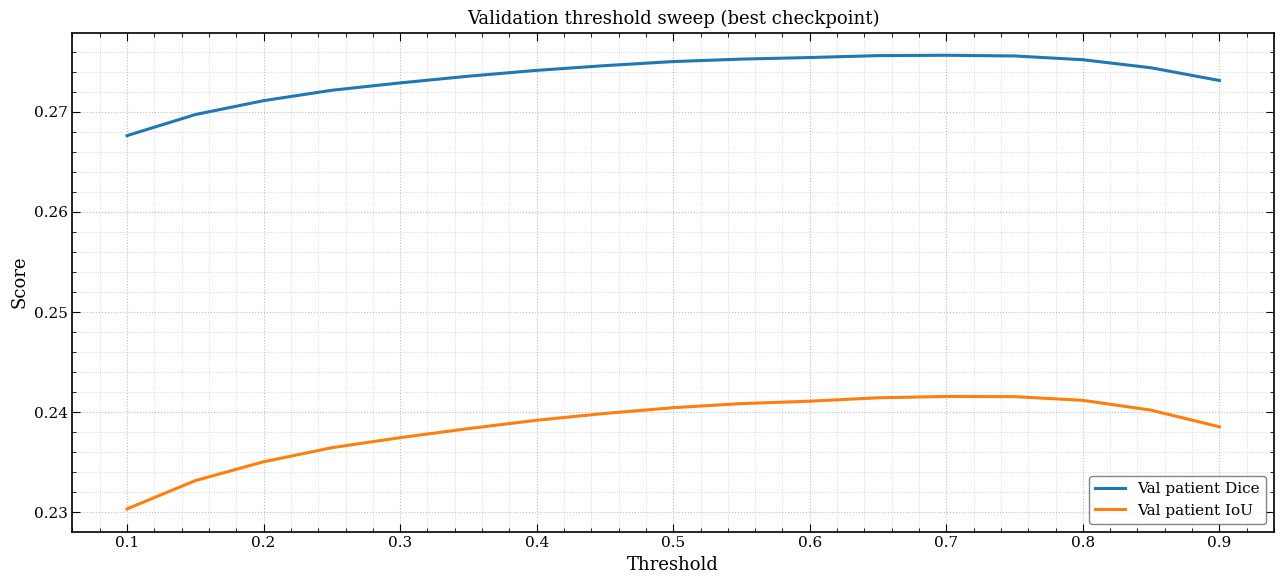

In [17]:
fig, ax = plt.subplots(figsize=(13, 6))
paper_axes(ax)

ax.plot(sweep_df["threshold"], sweep_df["patient_dice"], lw=2.2, label="Val patient Dice")
ax.plot(sweep_df["threshold"], sweep_df["patient_iou"],  lw=2.2, label="Val patient IoU")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Validation threshold sweep (best checkpoint)")
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig(OUT_DIR / "fig_threshold_sweep.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT_DIR / "fig_threshold_sweep.pdf", dpi=300, bbox_inches="tight")
plt.show()


## Final test evaluation + bootstrap 95% CI (patient-level)

We report patient-level mean Dice/IoU on the held-out test set with bootstrap confidence intervals.
This is a common, paper-friendly way to report reliability for limited-size medical datasets.


In [18]:
test_out = evaluate_slice_and_patient(best_model, test_loader, device, threshold=best_t, df_ref=test_df_ref)

print("Test patient Dice:", test_out["patient_dice_mean"])
print("Test patient IoU :", test_out["patient_iou_mean"])

test_patient_df = test_out["patient_df"].copy()
test_patient_df.head()


Test patient Dice: 0.256731539976089
Test patient IoU : 0.2251813226485352


,patient_id,dice,iou
0,TCGA_CS_6665_20010817,0.275453,0.211815
1,TCGA_DU_5855_19951217,0.376363,0.339260
2,TCGA_DU_6399_19830416,0.336999,0.318286
3,TCGA_DU_7300_19910814,0.192367,0.159766
4,TCGA_DU_7302_19911203,0.241278,0.192233


In [19]:
def bootstrap_ci(x, n_boot=5000, ci=95, seed=7):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    n = len(x)
    boots = []
    for _ in range(n_boot):
        samp = rng.choice(x, size=n, replace=True)
        boots.append(samp.mean())
    boots = np.array(boots)
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100 - (100-ci)/2)
    return float(x.mean()), float(lo), float(hi)

dice_mean, dice_lo, dice_hi = bootstrap_ci(test_patient_df["dice"].values)
iou_mean,  iou_lo,  iou_hi  = bootstrap_ci(test_patient_df["iou"].values)

print(f"Patient Dice mean (95% CI): {dice_mean:.4f} [{dice_lo:.4f}, {dice_hi:.4f}]")
print(f"Patient IoU  mean (95% CI): {iou_mean:.4f} [{iou_lo:.4f}, {iou_hi:.4f}]")


Patient Dice mean (95% CI): 0.2567 [0.2076, 0.3070]
Patient IoU  mean (95% CI): 0.2252 [0.1768, 0.2754]


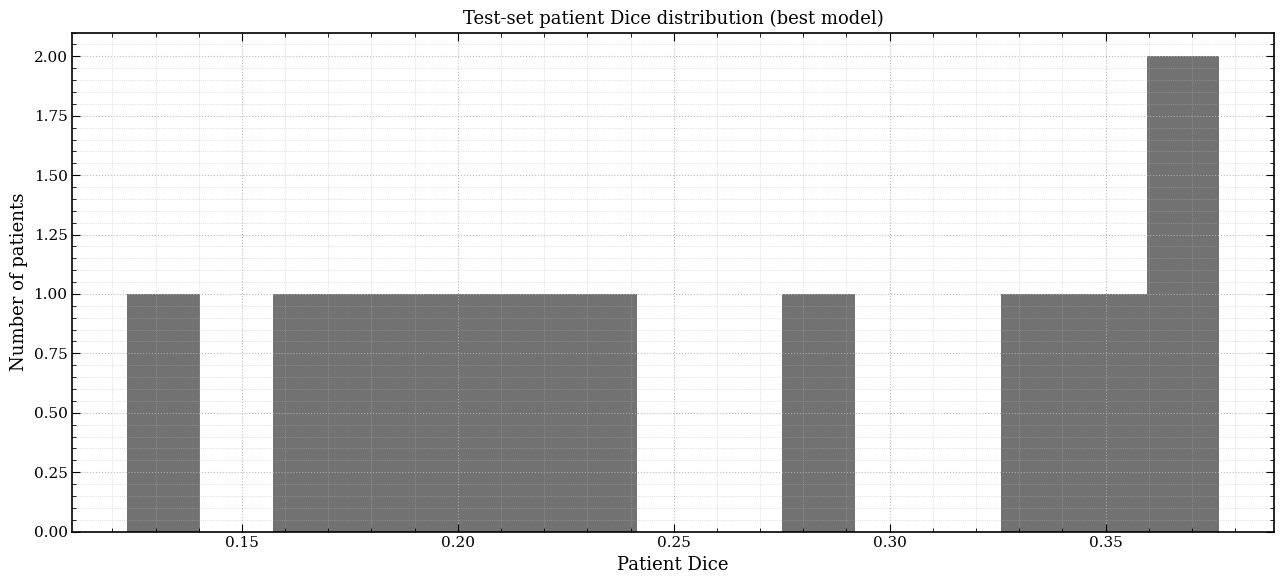

In [20]:
fig, ax = plt.subplots(figsize=(13, 6))
paper_axes(ax)

ax.hist(test_patient_df["dice"], bins=15, alpha=0.85, color="0.35")
ax.set_xlabel("Patient Dice")
ax.set_ylabel("Number of patients")
ax.set_title("Test-set patient Dice distribution (best model)")

plt.tight_layout()
plt.savefig(OUT_DIR / "fig_patient_dice_hist.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT_DIR / "fig_patient_dice_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()


## Export results: CSV + LaTeX table

We create:
- `ablation_results.csv`
- `ablation_results.tex`  (copy-paste into paper)
- `test_metrics.csv`


In [21]:
# Take best val patient Dice per experiment
best_per_exp = (hist_all.sort_values("val_patient_dice", ascending=False)
                .groupby("exp_name")
                .head(1)
                .sort_values("val_patient_dice", ascending=False)
                .reset_index(drop=True))

ablation_table = best_per_exp[[
    "exp_name", "use_attention", "freeze_encoder",
    "epoch", "val_patient_dice", "val_patient_iou", "val_loss"
]].copy()

ablation_table.rename(columns={
    "epoch": "best_epoch",
    "val_patient_dice": "val_patient_dice",
    "val_patient_iou": "val_patient_iou",
    "val_loss": "val_loss"
}, inplace=True)

ablation_table


,exp_name,use_attention,freeze_encoder,best_epoch,val_patient_dice,val_patient_iou,val_loss
0,Attn_Finetune,True,False,8,0.275017,0.240443,0.306763
1,NoAttn_Finetune,False,False,8,0.261979,0.227570,0.311946
2,NoAttn_Frozen,False,True,5,0.255955,0.219648,0.323548
3,Attn_Frozen,True,True,6,0.253038,0.216458,0.318740


In [22]:
ablation_csv = OUT_DIR / "ablation_results.csv"
ablation_tex = OUT_DIR / "ablation_results.tex"

ablation_table.to_csv(ablation_csv, index=False)

# Simple LaTeX export (clean)
latex_df = ablation_table.copy()
latex_df["use_attention"] = latex_df["use_attention"].map({True:"Yes", False:"No"})
latex_df["freeze_encoder"] = latex_df["freeze_encoder"].map({True:"Frozen", False:"Fine-tune"})

latex_str = latex_df.to_latex(index=False, float_format=lambda x: f"{x:.4f}")
ablation_tex.write_text(latex_str)

print("Saved:")
print("-", ablation_csv)
print("-", ablation_tex)


Saved:
- /kaggle/working/paper_outputs/ablation_results.csv
- /kaggle/working/paper_outputs/ablation_results.tex


In [23]:
test_metrics = pd.DataFrame([{
    "best_model": best_df.loc[0, "exp_name"],
    "best_threshold": best_t,
    "test_patient_dice_mean": dice_mean,
    "test_patient_dice_ci_low": dice_lo,
    "test_patient_dice_ci_high": dice_hi,
    "test_patient_iou_mean": iou_mean,
    "test_patient_iou_ci_low": iou_lo,
    "test_patient_iou_ci_high": iou_hi,
}])

test_metrics_path = OUT_DIR / "test_metrics.csv"
test_metrics.to_csv(test_metrics_path, index=False)

print("Saved:", test_metrics_path)
test_metrics


Saved: /kaggle/working/paper_outputs/test_metrics.csv


,best_model,best_threshold,test_patient_dice_mean,test_patient_dice_ci_low,test_patient_dice_ci_high,test_patient_iou_mean,test_patient_iou_ci_low,test_patient_iou_ci_high
0,Attn_Finetune,0.7,0.256732,0.207634,0.306958,0.225181,0.176761,0.275386


## Qualitative results (best model)

We export a clean panel: Input + GT overlay + Pred overlay for a few validation slices.


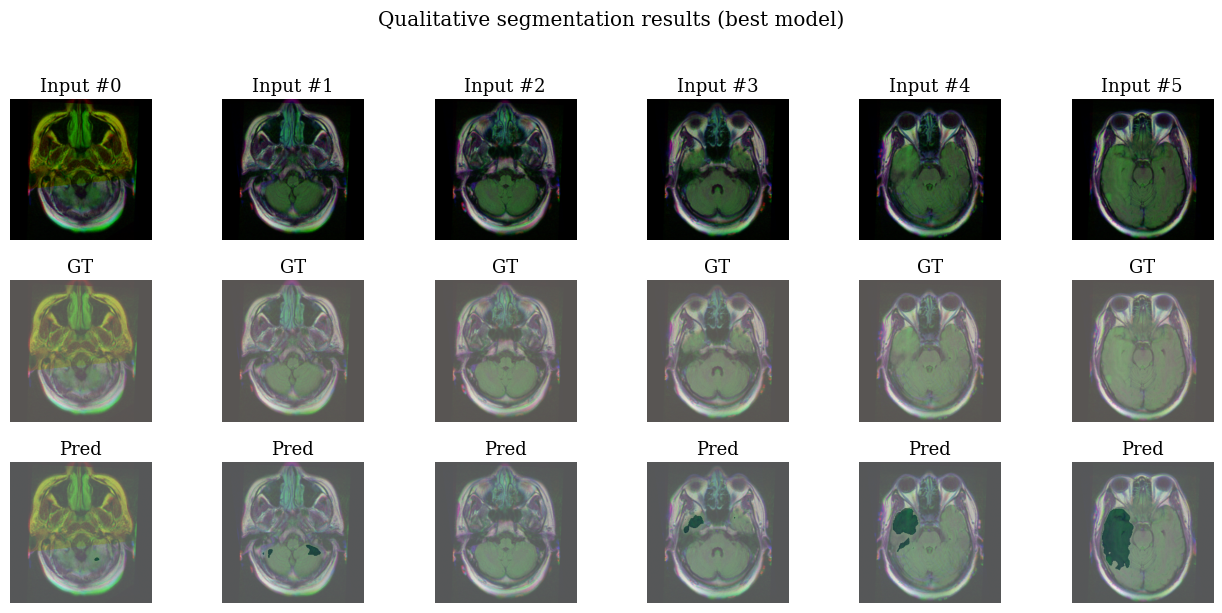

In [24]:
@torch.no_grad()
def qualitative_panel(model, loader, device, threshold, n=6, save_prefix="qual_panel"):
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    yb = yb.to(device)

    logits = model(xb)
    probs = torch.sigmoid(logits)
    pred = (probs > threshold).float()

    n = min(n, xb.size(0))
    fig, axes = plt.subplots(3, n, figsize=(13, 6))
    for ax in axes.ravel():
        paper_axes(ax)

    for i in range(n):
        img = np.clip(xb[i].detach().cpu().permute(1,2,0).numpy(), 0, 1)
        gt  = yb[i,0].detach().cpu().numpy()
        pr  = pred[i,0].detach().cpu().numpy()

        axes[0, i].imshow(img); axes[0, i].set_title(f"Input #{i}"); axes[0, i].axis("off")
        axes[1, i].imshow(img); axes[1, i].imshow(gt, alpha=0.35, cmap="Reds"); axes[1, i].set_title("GT"); axes[1, i].axis("off")
        axes[2, i].imshow(img); axes[2, i].imshow(pr, alpha=0.35, cmap="Blues"); axes[2, i].set_title("Pred"); axes[2, i].axis("off")

    fig.suptitle("Qualitative segmentation results (best model)", y=1.02)
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{save_prefix}.png", dpi=300, bbox_inches="tight")
    plt.savefig(OUT_DIR / f"{save_prefix}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

qualitative_panel(best_model, val_loader, device, best_t, n=6, save_prefix="fig_qualitative_val")


# Next steps

- Robustness tests (noise/contrast shifts on test)
- Statistical testing between ablation variants (paired bootstrap on patient Dice)
- Calibration/threshold stability analysis
